In [1]:
import sys
sys.path.insert(0, '../') 
import sphereGIS 
import conversions
import geopandas
import numpy
import pyhdf.SD
import math
import shapely
import matplotlib.pyplot as plt

In [2]:
# Load the polygon
polygons = geopandas.read_file('../data/santa_barbara.gpkg')
geom = polygons.iloc[0].geometry[0]
nodes = conversions.Nodes()
nodes.from_geom(geom)
nodes.drop_repetitive()
x_node, y_node, z_node = nodes.to_ecef()

In [3]:
# Getting the convex Hull Great Cirlces
convex_nodes = conversions.ConvexNodes()
convex_node_indices = sphereGIS.xyz2convex(x_node, y_node, z_node)
convex_nodes.from_indices(convex_node_indices, nodes)
gc = convex_nodes.to_gc()

In [4]:
# Loading granule
fname = '../data/MOD09.A2020032.1940.006.2020034015024.hdf'
hdf = pyhdf.SD.SD(fname)
lat = hdf.select('Latitude').get().flatten()
lon = hdf.select('Longitude').get().flatten()

x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

points = numpy.array([x, y, z]).transpose()

In [5]:
# Getting Candidates
dots = numpy.einsum('ji,mi->jm', points, gc)
n_constraints = len(gc)
inside_convex = numpy.where(numpy.sum(dots>0, axis=1)==n_constraints)[0]
candidate_points = points[inside_convex]

In [10]:
# We Have to be reloaded due to shuffling during set operation
nodes = conversions.Nodes()
nodes.from_geom(geom)
nodes_ecef = nodes.to_2d_ecef()

# Precompute edge great circles and their limts 
gcs = []
lim1 = []
lim2 = []
for i in range(0, len(nodes_ecef)-1):
    node1 = nodes_ecef[i] 
    node2 = nodes_ecef[i+1]
    gc = numpy.cross(node1, node2)
    gcs.append(gc)
    lim1.append(numpy.cross(gc, node1))
    lim2.append(numpy.cross(node2, gc))
    

def outbound_intersect(ray, point, gc, lim1, lim2):
    ray_intersect = numpy.cross(gc, ray)
    crosses = (numpy.dot(ray_intersect, lim1)  *  numpy.dot(ray_intersect, lim2)) > 0 
    if not crosses:
        return 0
    else: 
        crossing_direction = numpy.dot(point, gc)
        if crossing_direction < 0:
            return 1
        else:
            return -1
    return crosses 


ray_dest = numpy.array([0, 0, 1])
def test_point(point):
    ray = numpy.cross(point, ray_dest)
    net_out = 0
    for n in range(len(nodes_ecef)-1):
        net_out += outbound_intersect(ray, point, gcs[n], lim1[n], lim2[n])
    if net_out > 0:
        return True
    else:
        return False

In [11]:
inside_polygon = []
for i in inside_convex:
    point = points[i]
    if test_point(point):
        inside_polygon.append(i)

In [13]:
len(inside_polygon)

1633

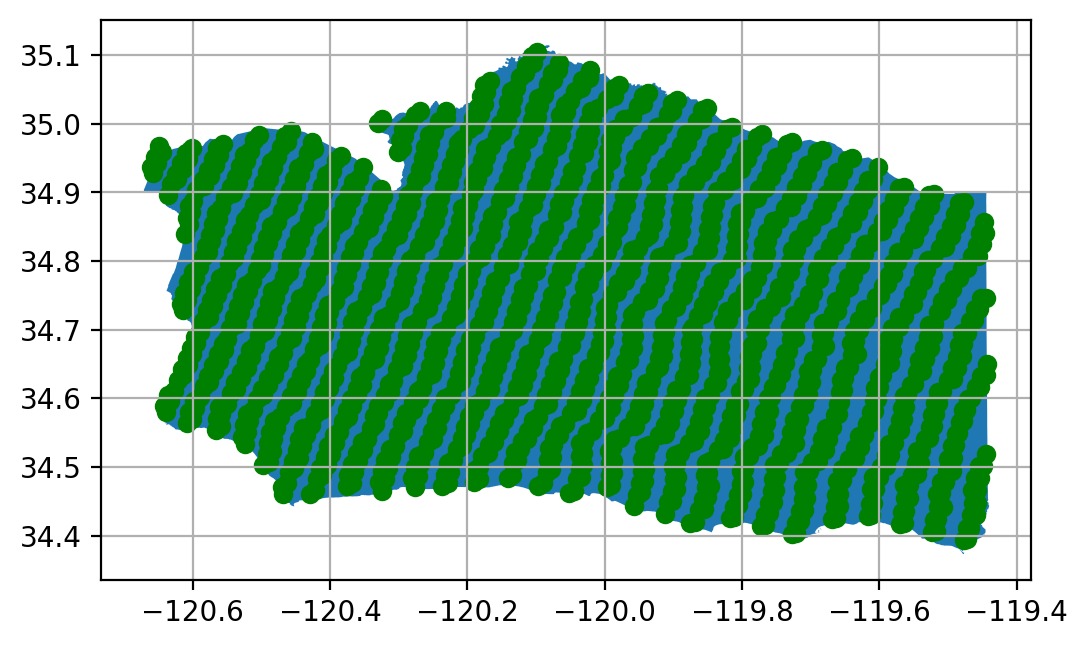

In [12]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax)

points_convex = []
for j in inside_convex:
    points_convex.append(shapely.geometry.Point(lon[j], lat[j]))
points_convex = geopandas.GeoDataFrame({'geom': points_convex}).set_geometry('geom')
#points_convex.plot(ax=ax, color='red')

points_poly = []
for j in inside_polygon:
    points_poly.append(shapely.geometry.Point(lon[j], lat[j]))
points_poly = geopandas.GeoDataFrame({'geom': points_poly}).set_geometry('geom')
points_poly.plot(ax=ax, color='green')